# Visualizing 5-fold cross-val results

In [1]:
from pathlib import Path

%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import average_precision_score, roc_auc_score

from hetnet_ml.src import plot_tools as pt

In [2]:
load_dir = Path('../2_pipeline/n_fold_CV_training/out/').resolve()

In [3]:
probas = dict()
coefs = dict()

# load the data given the right params
for file in load_dir.iterdir():
    if '.' not in file.name:
        date = file.name
        probas[date] = pd.read_csv(file.joinpath('predictions.csv'))
        coefs[date] = pd.read_csv(file.joinpath('coefs.csv'))

In [4]:
probas[date].head(2)

,c_id,c_name,d_id,d_name,status,holdout_fold,probas_0,c_percentile_0,d_percentile_0,probas_1,...,d_percentile_1,probas_2,c_percentile_2,d_percentile_2,probas_3,c_percentile_3,d_percentile_3,probas_4,c_percentile_4,d_percentile_4
0,Q1002165,fluticasone,Q1003534,bulbar syndrome,0,NaN,0.018208,0.461669,0.000478,0.018512,...,0.000478,0.018548,0.331705,0.000478,0.018759,0.209599,0.000478,0.019078,0.150563,0.000478
1,Q419663,methimazole,Q1003534,bulbar syndrome,0,NaN,0.018208,0.683797,0.000956,0.018512,...,0.000956,0.018548,0.458484,0.006695,0.018759,0.493311,0.000956,0.019078,0.479295,0.000956


In [5]:
n_folds = 5
dates = sorted(probas.keys())

In [6]:
probas[dates[0]].head(2)

,c_id,c_name,d_id,d_name,status,holdout_fold,probas_0,c_percentile_0,d_percentile_0,probas_1,...,d_percentile_1,probas_2,c_percentile_2,d_percentile_2,probas_3,c_percentile_3,d_percentile_3,probas_4,c_percentile_4,d_percentile_4
0,Q419724,fenofibrate,Q1004647,bullous pemphigoid,0,NaN,0.071126,0.897459,0.864025,0.003608,...,0.037296,0.003095,0.045070,0.038073,0.003534,0.000302,0.036519,0.002865,0.040835,0.000777
1,Q284321,mefenamic acid,Q1004647,bullous pemphigoid,0,NaN,0.071126,0.908348,0.866356,0.003608,...,0.745921,0.003095,0.090139,0.700078,0.003534,0.029038,0.846154,0.002865,0.010889,0.001554


In [7]:
train_data = []

for date in dates:
    this_probas = probas[date]
    for i in range(n_folds):
        
        train_test_data = this_probas.dropna(subset=['holdout_fold'])
        
        test_ys = train_test_data.query('holdout_fold == @i')['status']
        test_y_preds = train_test_data.query('holdout_fold == @i')['probas_{}'.format(i)]

        test_roc = roc_auc_score(test_ys, test_y_preds)
        test_prc = average_precision_score(test_ys, test_y_preds)
 
        all_ys = this_probas['status']
        all_y_preds = this_probas['probas_{}'.format(i)]

        all_roc = roc_auc_score(all_ys, all_y_preds)
        all_prc = average_precision_score(all_ys, all_y_preds)
        
        train_pos = train_test_data.query('holdout_fold != @i')['status'].sum()
        train_neg = train_test_data.query('holdout_fold != @i and status == 0').shape[0]
        test_pos = train_test_data.query('holdout_fold == @i')['status'].sum()
        test_neg = train_test_data.query('holdout_fold == @i and status == 0').shape[0]
        
        total_pos = train_pos + test_pos
        total_neg = train_neg + test_neg
        
        
        fold_data = {'train_pos': train_pos, 'train_neg': train_neg, 'test_pos': test_pos, 
                     'test_neg': test_neg, 'total_pos': total_pos, 'total_neg': total_neg,
                     'test_roc': test_roc, 'test_prc': test_prc, 'all_roc': all_roc, 'all_prc': all_prc,
                     'date': date, 'fold': i}
        fold_data = pd.DataFrame(fold_data, index=[1])
        
        
        train_data.append(fold_data)

In [8]:
train_data = pd.concat(train_data).set_index(['date', 'fold'])
train_data

train_pos  train_neg  test_pos  test_neg  total_pos  \
date       fold                                                        
2017-01-16 0         17300     173000      4325     43250      21625   
           1         17300     173000      4325     43250      21625   
           2         17300     173000      4325     43250      21625   
           3         17300     173000      4325     43250      21625   
           4         17300     173000      4325     43250      21625   
2018-02-05 0         13205     132056      3302     33014      16507   
           1         13205     132056      3302     33014      16507   
           2         13206     132056      3301     33014      16507   
           3         13206     132056      3301     33014      16507   
           4         13206     132056      3301     33014      16507   
2018-11-12 0         28162     281624      7041     70406      35203   
           1         28162     281624      7041     70406      35203   
           2         28162     281624      7041     70406      35203   
           3         28163     281624      7040     70406      35203   
           4         28163     281624      7040     70406      35203   
2019-09-13 0         29804     298040      7451     74510      37255   
           1         29804     298040      7451     74510      37255   
           2         29804     298040      7451     74510      37255   
           3         29804     298040      7451     74510      37255   
           4         29804     298040      7451     74510      37255   

                 total_neg  test_roc  test_prc   all_roc   all_prc  
date       fold                                                     
2017-01-16 0        216250  0.715262  0.428239  0.709906  0.127678  
           1        216250  0.712553  0.416011  0.705136  0.124837  
           2        216250  0.702613  0.402463  0.706677  0.121640  
           3        216250  0.702977  0.405407  0.703333  0.124933  
           4        216250  0.696837  0.402117  0.700748  0.126501  
2018-02-05 0        165070  0.796176  0.539833  0.803458  0.162186  
           1        165070  0.801543  0.542526  0.797758  0.151153  
           2        165070  0.794946  0.533200  0.797544  0.153125  
           3        165070  0.798488  0.531186  0.797046  0.148702  
           4        165070  0.799001  0.539284  0.795001  0.161272  
2018-11-12 0        352030  0.925202  0.757048  0.924419  0.257537  
           1        352030  0.917156  0.736089  0.916686  0.231356  
           2        352030  0.921708  0.749420  0.924554  0.257230  
           3        352030  0.927125  0.767213  0.925163  0.254776  
           4        352030  0.924778  0.758398  0.925066  0.255446  
2019-09-13 0        372550  0.923446  0.757229  0.926207  0.244443  
           1        372550  0.926496  0.759774  0.926215  0.245125  
           2        372550  0.925829  0.758394  0.926359  0.244950  
           3        372550  0.929975  0.770002  0.925523  0.245948  
           4        372550  0.924453  0.760239  0.925628  0.246851

### ROC Curvs for each 5-fold individually

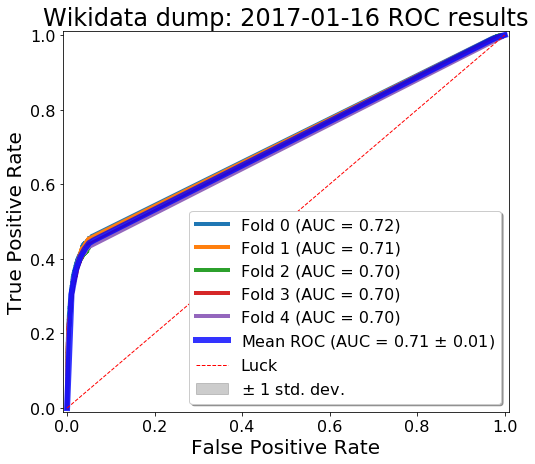

In [9]:
date = dates[0]

ys = []
y_preds = []

for i in range(n_folds):
    y = probas[date].query('holdout_fold == @i')['status']
    y_pred = probas[date].query('holdout_fold == @i')['probas_{}'.format(i)]
    
    pt.graph_single_roc(y, y_pred, label='Fold {}'.format(i))
    
    ys.append(y)
    y_preds.append(y_pred)
    
pt.graph_mean_roc(ys, y_preds)
pt.graph_roc_boilerplate('Wikidata dump: {} ROC results'.format(date));

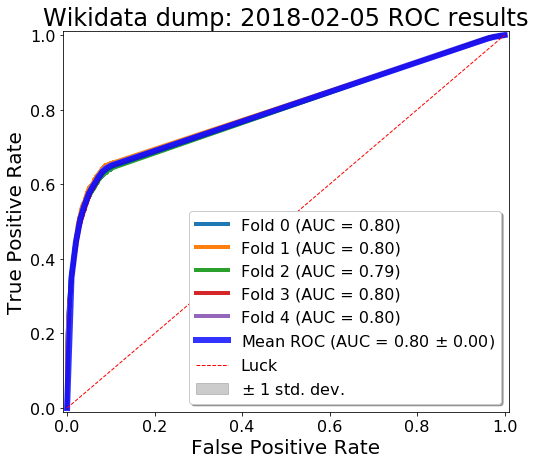

In [10]:
date = dates[1]

ys = []
y_preds = []

for i in range(n_folds):
    y = probas[date].query('holdout_fold == @i')['status']
    y_pred = probas[date].query('holdout_fold == @i')['probas_{}'.format(i)]
    
    pt.graph_single_roc(y, y_pred, label='Fold {}'.format(i))
    
    ys.append(y)
    y_preds.append(y_pred)
    
pt.graph_mean_roc(ys, y_preds)
pt.graph_roc_boilerplate('Wikidata dump: {} ROC results'.format(date));

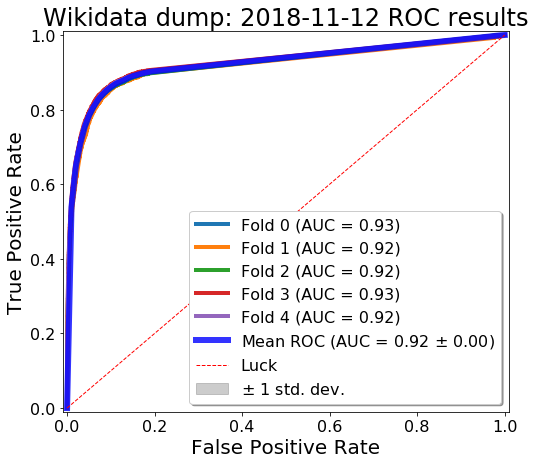

In [11]:
date = dates[2]

ys = []
y_preds = []

for i in range(n_folds):
    y = probas[date].query('holdout_fold == @i')['status']
    y_pred = probas[date].query('holdout_fold == @i')['probas_{}'.format(i)]
    
    pt.graph_single_roc(y, y_pred, label='Fold {}'.format(i))
    
    ys.append(y)
    y_preds.append(y_pred)
    
pt.graph_mean_roc(ys, y_preds)
pt.graph_roc_boilerplate('Wikidata dump: {} ROC results'.format(date));

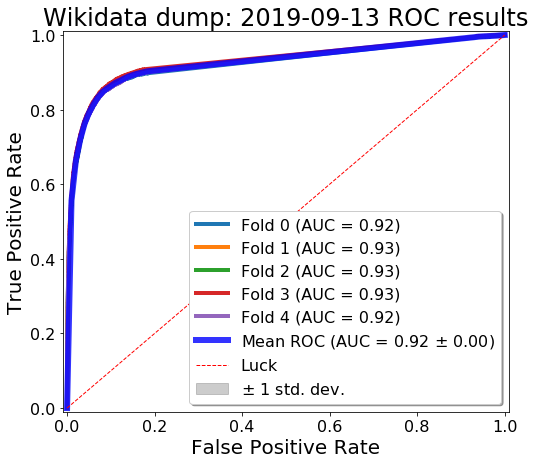

In [12]:
date = dates[3]

ys = []
y_preds = []

for i in range(n_folds):
    y = probas[date].query('holdout_fold == @i')['status']
    y_pred = probas[date].query('holdout_fold == @i')['probas_{}'.format(i)]
    
    pt.graph_single_roc(y, y_pred, label='Fold {}'.format(i))
    
    ys.append(y)
    y_preds.append(y_pred)
    
pt.graph_mean_roc(ys, y_preds)
pt.graph_roc_boilerplate('Wikidata dump: {} ROC results'.format(date));

## RPC Plots of the aggregate results, Test Sets only

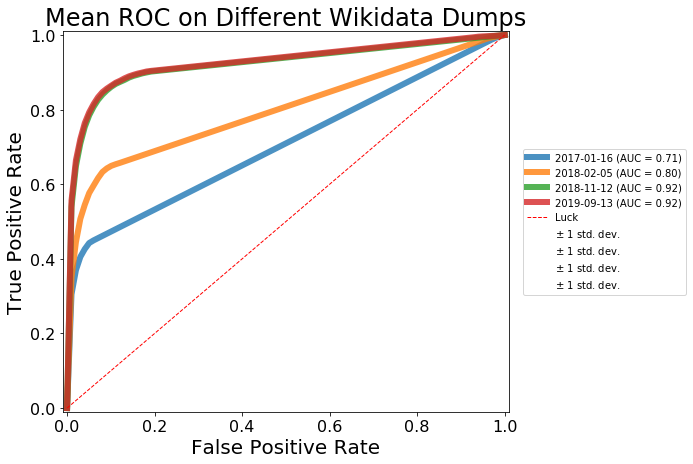

In [13]:
for date in dates:

    this_probas = probas[date]
    
    ys = []
    y_preds = []
    for i in range(n_folds):
        ys.append(this_probas.query('holdout_fold == @i')['status'])
        y_preds.append(this_probas.query('holdout_fold == @i')['probas_{}'.format(i)])
        
    
    pt.graph_mean_roc(ys, y_preds, label=date, fill_alpha=False)
pt.graph_roc_boilerplate('Mean ROC on Different Wikidata Dumps');
plt.legend(loc=6, bbox_to_anchor=(1.02, .5));

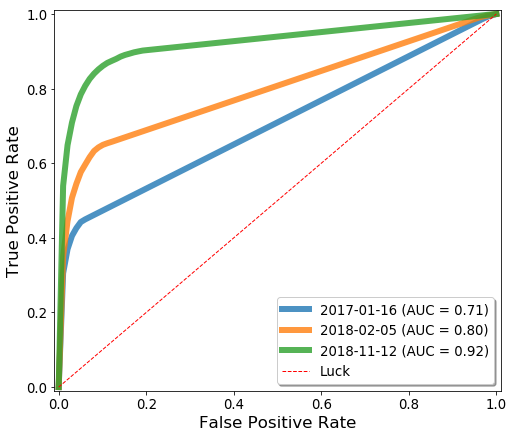

In [14]:
to_plot = ['2017-01-16', '2018-02-05', '2018-11-12']

for date in to_plot:

    this_probas = probas[date]
    
    ys = []
    y_preds = []
    for i in range(n_folds):
        ys.append(this_probas.query('holdout_fold == @i')['status'])
        y_preds.append(this_probas.query('holdout_fold == @i')['probas_{}'.format(i)])
        
    
    pt.graph_mean_roc(ys, y_preds, label=date, fill_between=False)
pt.graph_roc_boilerplate('', size=20)
plt.savefig('../5-fold.svg');

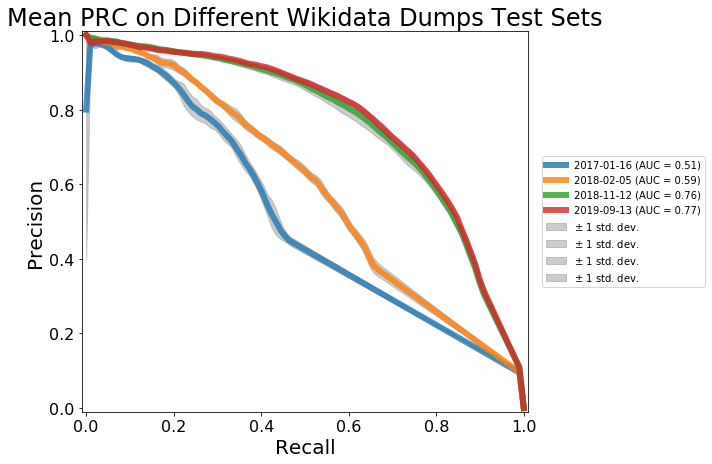

In [15]:
for date in dates:
    
    this_probas = probas[date]
    
    ys = []
    y_preds = []
    for i in range(n_folds):
        ys.append(this_probas.query('holdout_fold == @i')['status'])
        y_preds.append(this_probas.query('holdout_fold == @i')['probas_{}'.format(i)])
        
    
    pt.graph_mean_prc(ys, y_preds, label=date)
pt.graph_prc_boilerplate('Mean PRC on Different Wikidata Dumps Test Sets')
plt.legend(loc=6, bbox_to_anchor=(1.02, .5));

## Now ROC for all CD Pairs, all folds

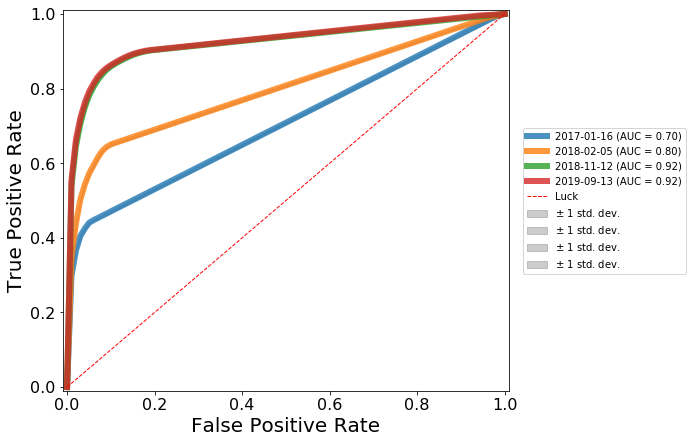

In [16]:
for date in dates:

    this_probas = probas[date]
    
    ys = []
    y_preds = []
    for i in range(n_folds):
        ys.append(this_probas['status'])
        y_preds.append(this_probas['probas_{}'.format(i)])
        
    
    pt.graph_mean_roc(ys, y_preds, label=date)
pt.graph_roc_boilerplate('');
plt.legend(loc=6, bbox_to_anchor=(1.02, .5));

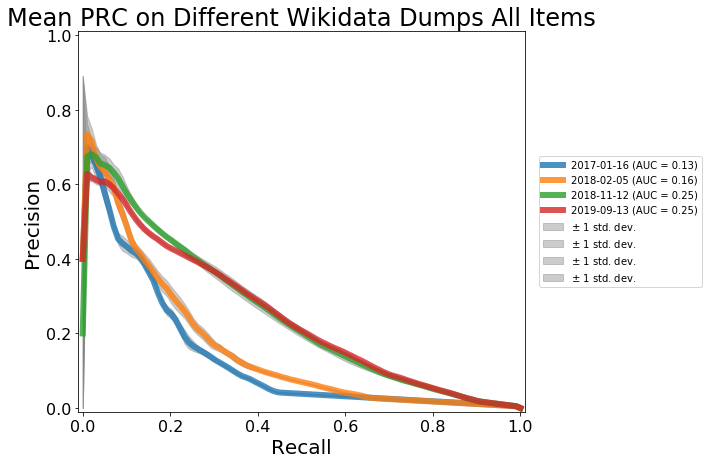

In [17]:
for date in dates:

    this_probas = probas[date]
    
    ys = []
    y_preds = []
    for i in range(n_folds):
        ys.append(this_probas['status'])
        y_preds.append(this_probas['probas_{}'.format(i)])
        
    
    pt.graph_mean_prc(ys, y_preds, label=date)
pt.graph_prc_boilerplate('Mean PRC on Different Wikidata Dumps All Items');
plt.legend(loc=6, bbox_to_anchor=(1.02, .5));